In [1]:
import re
import keras
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
N_SAMPLES = 240000
N_CHANNELS = 16
MODEL_FILE = 'out/models/b-f3-e10-auc0.62391'
WAVEFORMS_DIR = 'out/waveforms'

In [3]:
test_files = pd.read_csv('sample_submission.csv').File.values
model = keras.models.load_model(MODEL_FILE)

In [4]:
def process_batch(files, waves, model, res_df=None):
    waves = np.array(waves, dtype=np.float32).reshape(-1, N_CHANNELS, N_SAMPLES, 1)
    y_p = model.predict(waves, verbose=False, batch_size=2)
    batch_df = pd.DataFrame({'File': files, 'Class': y_p.T[0]})

    if res_df is None:
        return batch_df
    else:
        return res_df.append(batch_df)

In [5]:
BATCH_SIZE = 100
batch_files = []
batch_waves = []
res_df = None

for f in tqdm(test_files):
    
    fid = re.findall(r'(.+)\.mat$', f)[0]
    batch_files.append(f)
    
    # read wave
    wave_file = WAVEFORMS_DIR + '/' + fid + '.npy'
    wave = np.load(wave_file)
    batch_waves.append(wave)
    
    if len(batch_files) == BATCH_SIZE:
        res_df = process_batch(batch_files, batch_waves, model, res_df)
        batch_files = []
        batch_waves = []

if len(batch_files):
    res_df = process_batch(batch_files, batch_waves, model, res_df)

100%|██████████| 6126/6126 [37:07<00:00,  4.32it/s]


In [6]:
res_df.to_csv('subm-c.csv', index=False, columns=['File', 'Class'], float_format='%.8f')

(array([ 5957.,   169.]),
 array([  2.85748479e-06,   1.47301538e-01,   2.94600219e-01]),
 <a list of 2 Patch objects>)

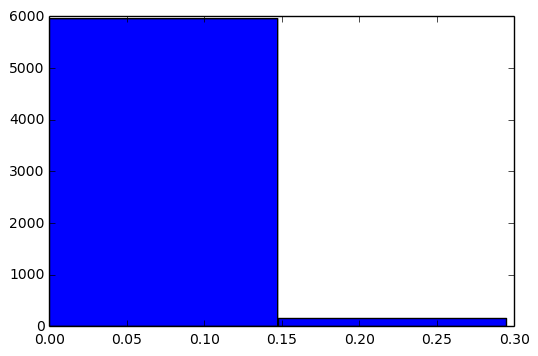

In [7]:
plt.hist(res_df.Class.values, bins=2)